# Week 13 (Wednesday), AST 8581 / PHYS 8581 / CSCI 8581: Big Data in Astrophysics

### Michael Coughlin <cough052@umn.edu>, Jie Ding <dingj@umn.edu>

# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


# Where do we stand?

Foundations of Data and Probability -> Statistical frameworks (Frequentist vs Bayesian) -> Estimating underlying distributions -> Analysis of Time series (periodicity) -> Analysis of Time series (variability) -> Analysis of Time series (stochastic processes) -> Gaussian Processes -> Decision Trees / Regression -> Dimensionality Reduction -> Principle Component Analysis -> Clustering -> Density Estimation / Anomaly Detection -> Supervised Learning -> Deep Learning -> Introduction to Databases - SQL -> Introduction to Databases - NoSQL -> Introduction to Multiprocessing -> Introduction to GPUs

GPU's are Graphics Processing Units that have a large number of cores that can operate in parallel on data. Compare that to CPU's, which have a low number of cores (typically 4-8 for desktops, and 16-128 for single servers). Originally, these were used primarily to render graphics for games, but people quickly realized that these highly parallel architectures could be leveraged for general purpose computations (GPGPU).

As you can see in the figure, each core of a CPU has its own local cache (L1) which is rather small, but has very fast access. All the CPU's will share an L3 cache, which is some sort of global memory for this set of cores.

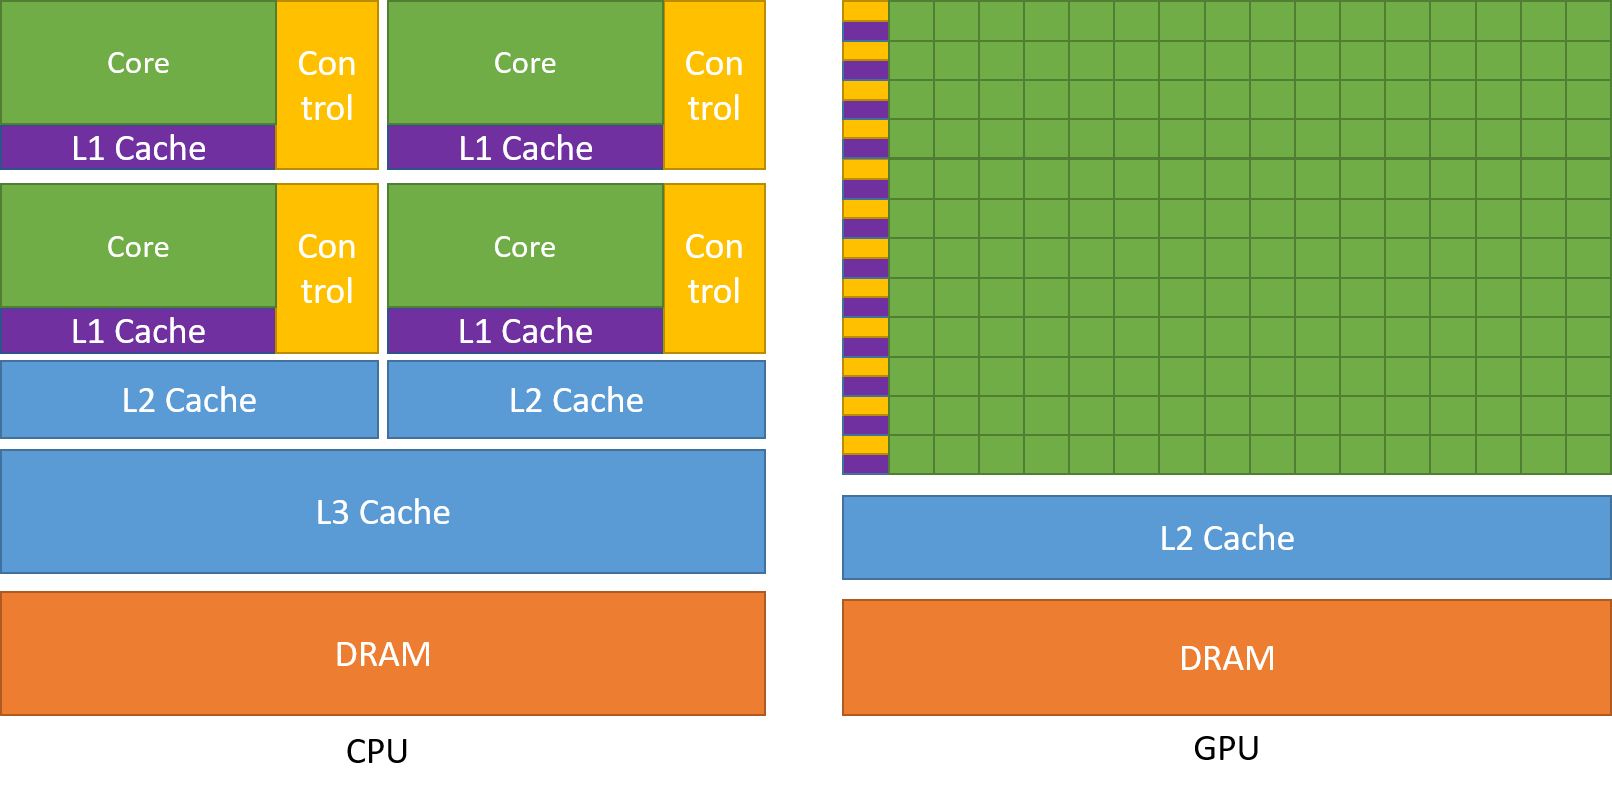

Compare that to a GPU, where a lower level cache is shared by many cores. Each core is less powerful and has less cache space that it can use itself, but this is made up for by having many more cores that can run at once.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [1]:
from numba import jit, njit, vectorize, cuda
import math
import numpy as np

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
a = np.ones((1, 100), dtype=np.float64)
b = np.ones((100, 1), dtype=np.float64)



In [4]:
@vectorize(['float64(float64, float64)'], target='cuda')
def vecCuda_func(a, b):
  for i in range(100000):
    a = math.pow(a*b, 1./2)/math.exp(a*b/1000)
  return a

In [5]:
# Woah!!
%timeit res = vecCuda_func(a, b)

1 loop, best of 5: 438 ms per loop


# 6. Running your functions on GPU


In [6]:
@cuda.jit
def cudaKernal_func(a, b, result): # cuda.jit does not return result yet
  pos = cuda.grid(1)
  if (pos < a.shape[1]) and (pos < b.shape[0]):
    for i in range(100000):
      result[pos] = math.exp(a[0][pos]*b[pos][0])

In [7]:
result = np.zeros((100,), dtype=np.float64)

In [8]:
threadsperblock = 32
blockspergrid = (100 + 31) // 32 # blockspergrid = (array.size + (threadsperblock - 1)) // threadsperblock

%timeit cudaKernal_func[threadsperblock, blockspergrid](a, b, result)

The slowest run took 7.81 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 78.3 ms per loop


In [9]:
result.shape

(100,)

In [ ]:
#
# Here, we have only used it for 1D arrays. You can use it for any Tensor. For eg:
# For 2D array operations you would have used: x, y = cuda.grid(2)
#

In [10]:
@cuda.jit(device=True)
def cudaDevice_func(a, b):
  for i in range(100000):
    a = math.exp(a*b)
  return a

In [11]:
@cuda.jit
def cudaKernal_func2(a, b, result): # cuda.jit does not return result yet
  pos = cuda.grid(1)
  if (pos < a.shape[1]) and (pos < b.shape[0]):
    result[pos] = cudaDevice_func(a[0][pos], b[pos][0])

In [12]:
%timeit cudaKernal_func2[threadsperblock, blockspergrid](a, b, result)

The slowest run took 5.75 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 51.5 ms per loop


# Initial

### Torch:

In [ ]:
!pip -q install torchvision

### Dask:

In [ ]:
# https://stackoverflow.com/questions/49853303/how-to-install-pydot-graphviz-on-google-colab?rq=1
!pip -q install graphviz 
!apt-get install graphviz -qq
!pip -q install pydot

# Import

In [13]:
import numpy as np
import pandas as pd
from multiprocessing import Pool, Process
import torch

In [14]:
import matplotlib.pyplot as plt

# 5. Pycuda (Optional)

## Kernels
**Kernel** functions are functions that will be executed on the GPU to call a number of threads.

Each thread has a unique ID in a particular dimension, defined by a **thread block**, which can be 1D, 2D, or 3D. Each block can have up to 1024 threads, but multiple thread blocks can run;  this gives the total number of threads running as threads_per_block * num_blocks.

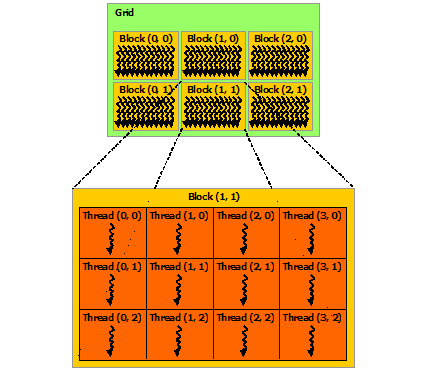


In [15]:
!pip install pycuda # install cuda
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 78 kB 7.5 MB/s 
     |████████████████████████████████| 68 kB 7.1 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=626634 sha256=b3210dc4dfd9c342523abaca8c4ef958ea10745de82ff9811c7b278f8eca45a9
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2022.1.4-py2.py3-none-any.whl size=64565 sha256=379613df29c91cadcd424838564d1e848cbe8dc5a997b1c32305e5d30a65aee3
  Stored in directory: /root/.cache/pip/wheels/3d/fa/11/780768f5d348db6336b7237aa800c324685d6fc792a7bfde55
Successfully built pycuda pytools


In [16]:
import numpy
a = numpy.random.randint(1, 9, (10000, 10000))
a = a.astype(numpy.float32) # Most nVidia devices support single precision

In [ ]:
# The main drawback of Pycuda is that you will have to write C code
# to perform any task and pass it to SourceModule...

mod = SourceModule("""
  __global__ void doublify(float *a)
  {
    int idx = threadIdx.x + threadIdx.y*4;
    a[idx] *= 2;
  }
  """)

# As we saw in Numba post, you have to know which thread we are in to compute index(s) to operate on.
# Here we get that from threadId.

In [ ]:
# Get reference to function and initialize it, passing array and block size (4x4).
func = mod.get_function("doublify")

In [ ]:
a_gpu = cuda.mem_alloc(a.nbytes) # Allocate memory on GPU
cuda.memcpy_htod(a_gpu, a) # Send array to GPU. Now your array is within variable a_gpu
a_gpu = cuda.to_device(a)
func(a_gpu, block=(4, 4, 1))
a_doubled = numpy.empty_like(a) # Copy array from gpu to cpu
cuda.memcpy_dtoh(a_doubled, a_gpu)
a_doubled[0][0:10], a[0][0:10]

AttributeError: ignored

In [ ]:
# We can also simply use cuda.InOut which sends array to GPU
# and then retrives back again:
func(cuda.InOut(a), block=(4, 4, 1)) # block takes Block size which can be 3D. Block size gives us number of threads in Block. (No. of threads should be <= 512)
a

array([[ 4., 14.,  6., ...,  2.,  3.,  5.],
       [ 3.,  3.,  1., ...,  4.,  6.,  4.],
       [ 4.,  5.,  7., ...,  1.,  1.,  7.],
       ...,
       [ 4.,  2.,  5., ...,  2.,  4.,  7.],
       [ 1.,  3.,  6., ...,  4.,  2.,  2.],
       [ 6.,  5.,  6., ...,  2.,  4.,  6.]], dtype=float32)

In [ ]:
# Whereas a grid is 2D and can have max of 1000's of blocks. As before its dimensions give number of blocks. 

## Memory Access Costs

Let's observe how memory access costs change runtime of kernel functions. 
There are several different types of memory; of note are **global** and **shared** memory. Global memory is heap-space memory on the GPU that's accessible from any thread, block, and grid (although, it may not be accessible at all times to all threads, but we won't talk about concurrency). This resides on a larger block of memory, but is farther away from each threads. Shared memory will act like a locally-managed L1 or L2 cache. Typically, there will be too much data to put directly into all the registers, so these cachese will need to be used.

Memory that is physically closer to each thread will be faster to access, but there will be less of this available. We can use matrix multiplication as a great test to see how fast this runs.

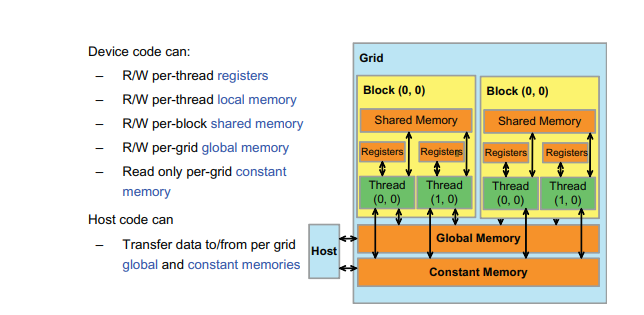

In [ ]:
mod = SourceModule("""
  __global__ void matmul_kernel(float* d_M, float* d_N, float* d_P, int width)
  {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int column = blockIdx.x * blockDim.x + threadIdx.x;
    
    if((row < width) && (column < width))
    {
      float value = 0;
      // each thread computes one element of the block sub-matrix
      for (int k = 0; k < width; ++k)
      {
        value += d_M[row * width + k] * d_N[k * width + column];
      }
      d_P[row * width + column] = value;
    }
  }
  """)

In [ ]:
# In python
from pycuda import gpuarray

func = mod.get_function("matmul_kernel")

# Make 2 16x16 arrays of 32 bit floats
M = np.random.rand() * np.ones((16, 16), dtype=np.float32)
N = 5 * np.ones((16, 16), dtype=np.float32)
d_P = np.ones((16, 16), dtype=np.float32)


M_matmul_kernel_gpu = gpuarray.to_gpu(M)
N_matmul_kernel_gpu = gpuarray.to_gpu(N)

d_P_gpu = gpuarray.empty(shape=M.shape, dtype=np.float32)
func(M_matmul_kernel_gpu, N_matmul_kernel_gpu, d_P_gpu, np.int32(16), block = (16, 16, 1))

d_P_ret = d_P_gpu.get()
print(d_P_ret)

#func(cuda.In(M), cuda.In(N), cuda.InOut(d_P), block=(8, 8, 1))


#print(d_P)


[[8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808
  8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808]
 [8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808
  8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808]
 [8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808
  8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808]
 [8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808
  8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808]
 [8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808
  8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808]
 [8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808
  8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808]
 [8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808 8.476808
  8.476808 8.476808 8.476808 8.4

For things that are accessed frequently, shared memory should be be used when possible. This will lead to one access in global memory to read it and copy it to shared memory, rather than having to do an access in global memory every time it needs to be accessed. This will also be preferable to placing the data 
in a register, as then the data is going to be private to one thread, rather than accessible from all threads in a warp (a set of 32 threads that operate together).

But, the tradeoff of shared memory is that it's smaller, so less data can fit into there. Sometimes, portions of global memory will need to be partitioned into tiles so that each tile fits into shared memory, and then threadblocks can operate on that tile.



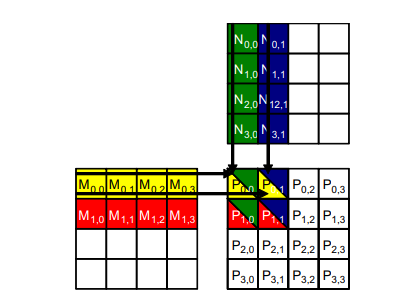




Let's examine this kernel that used tiling and shared memory to do the same matrix multiplication as above.

In [ ]:
mod = SourceModule('''
__global__ void matmul_shared_kernel(float* d_M, float* d_N, float* d_P, int width)
{
	int TILE_WIDTH = 8;
	__shared__ float M_shared[8][8];
	__shared__ float N_shared[8][8];

	int bx = blockIdx.x; 
	int by = blockIdx.y;
	int tx = threadIdx.x; 
	int ty = threadIdx.y;

	// Identify the row and columnumn of the d_P element to work on
	int row = by * 8 + ty;
	int column = bx * 8 + tx;
	float Pvalue = 0;

	// Loop over the d_M and d_N tiles required to compute d_P element
	for (int m = 0; m < width / 8; m++)
	{
		// Coolaborative loading of d_M and d_N tiles into shared memory
		M_shared[ty][tx] = d_M[row * width + m * 8 + tx];
		N_shared[ty][tx] = d_N[(m * 8 + ty) * width + column];
		__syncthreads();
		
		for(int k = 0; k < 8; k++)
		{
			Pvalue += M_shared[ty][k] * N_shared[k][tx];
		}

		__syncthreads();
	}

	d_P[row*width + column] = Pvalue;
}
  ''')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(5): warning: variable "TILE_WIDTH" was declared but never referenced




In [ ]:
# In python
from pycuda import gpuarray

func = mod.get_function("matmul_shared_kernel")

# Make 2 16x16 arrays of 32 bit floats
M = np.random.rand() * np.ones((32, 32), dtype=np.float32)
N = 5 * np.ones((32, 32), dtype=np.float32)
d_P = np.ones((32, 32), dtype=np.float32)


M_matmul_kernel_gpu = gpuarray.to_gpu(M)
N_matmul_kernel_gpu = gpuarray.to_gpu(N)

d_P_gpu = gpuarray.empty(shape=M.shape, dtype=np.float32)
func(M_matmul_kernel_gpu, N_matmul_kernel_gpu, d_P_gpu, np.int32(8), block = (4, 4, 1))

d_P_ret = d_P_gpu.get()
print(d_P_ret)

[[8.195046 8.195046 8.195046 ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 ...
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]]


## Syncing Data
Threads in a block will all utilize the same shared memory. Synchronization points in the kernel can be used by calling ```__syncthreads()``` to prevent overwriting; this tells CUDA to place a barrier, where each thread must wait until all other threads have caught up to that point. 

In the shared memory kernel, we sync after copying the data to the shared memory tile so that all threads can ensure they have data filled into their shared memory buffers. We also sync'd at the end of every loop on the for loop to prevent data overwriting.

Taking a look at this parallel prefix sum, there will be a few spots where we'd need to sync every thread within a block, but you will have to fill those in.

In [ ]:
mod = SourceModule("""
__global__ void bad_parallel_prefixsum(double *in_vector, double *out_vector)
{
     __shared__ double shared_tmp_sumbuffer[1024];     
     int tid = threadIdx.x;     
     shared_tmp_sumbuffer[tid] = in_vector[tid];
     
     // begin parallel prefix sum algorithm
     
     int iter = 1;
     for (int i=0; i < 10; i++)
     {
         if (tid >= iter )
         {
             shared_tmp_sumbuffer[tid] = shared_tmp_sumbuffer[tid] + shared_tmp_sumbuffer[tid - iter];            
         }
         
         iter *= 2;
     }
         
    out_vector[tid] = shared_tmp_sumbuffer[tid];
}
""")

In [ ]:
parallel_prefix_gpu = mod.get_function("bad_parallel_prefixsum")

in_vec = np.random.randn(512).astype(np.float32)
in_vec_gpu = gpuarray.to_gpu(in_vec)

# Define outvec on the gpu
# func(in_vec_gpu, outvec_gpu, block=(512, 1, 1))


#### Examples:

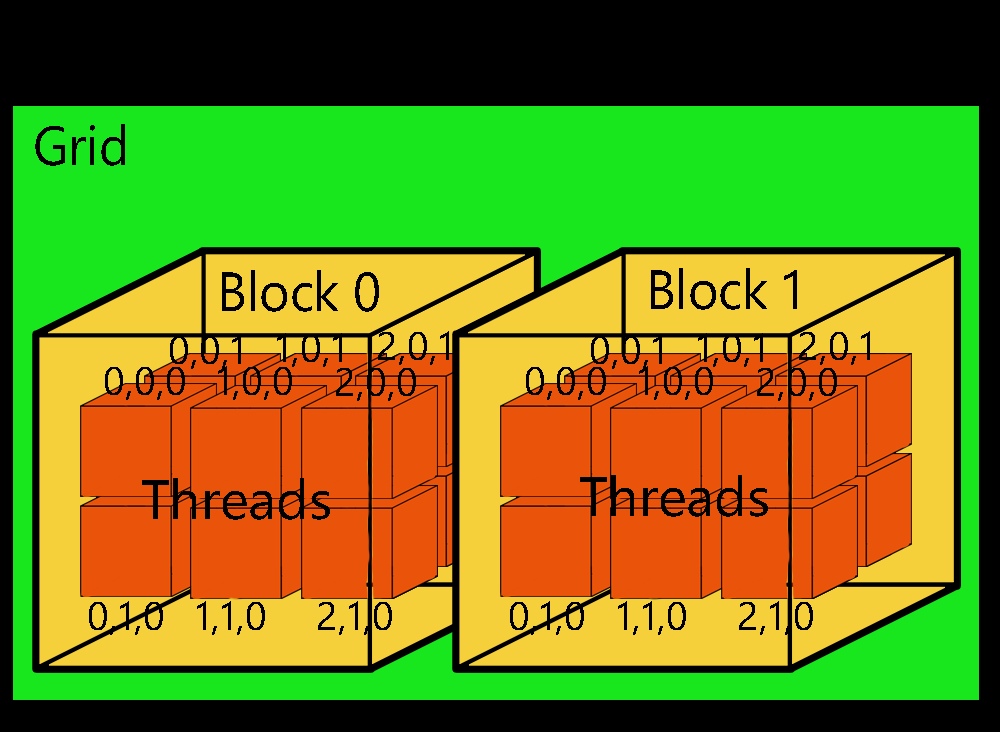Image: https://raw.githubusercontent.com/andreajeka/CUDAThreadIndexing/master/images/1dgrid3dblock.png


As shown in image, if we use 1D grid and 3D blocks, that is how you can think of it. Each of the thread sub-blocks contain one thread. Structure like this makes indexing of threads in grid easier.

In [ ]:
#
# 1D grid and 1D block
#

temp = np.zeros((4000,))
temp = temp.astype(np.float32)
mod = SourceModule("""
  __global__ void cuda_func(float *a)
  {
    int idx = blockDim.x*blockIdx.x + threadIdx.x;  // Go to block + Go to thread
    if(idx < 4000){
       a[idx] = (float) threadIdx.x; // One thread operating on one index. There are total of (4127)//128 = 32 blocks, each having 128 threads. Total 4096 threads.
    }
  }
  """)
func = mod.get_function("cuda_func")
func(cuda.InOut(temp), grid=((4000+127)//128, 1), block=(128, 1, 1))
temp[-33:]

TypeError: ignored

In [ ]:
#
# 1D grid and 2D block
#

temp = numpy.zeros((4000,))
temp2 = numpy.zeros((4000,))
temp = temp.astype(numpy.float32)
temp2 = temp2.astype(numpy.float32)
mod = SourceModule("""
  __global__ void cuda_func(float *a, float *b)
  {
    int idx = blockDim.x*blockDim.y*blockIdx.x + blockDim.x* threadIdx.y + threadIdx.x;  // Go to block + Go to row to current thread + Go to thread
    if(idx < 4000){
       a[idx] = (float) threadIdx.x; // One thread operating on one index. There are total of (4063)//64 = 63 blocks, each having (8x8)=64 threads. Total 4032 threads.
       b[idx] = (float) threadIdx.y;
    }
  }
  """)
func = mod.get_function("cuda_func")
func(cuda.InOut(temp), cuda.InOut(temp2), grid=((4000+63)//64, 1), block=(8, 8, 1))
temp[-10:], temp2[-10:]

In [ ]:
#
# 1D grid and 3D block
#

temp = numpy.zeros((4000,))
temp = temp.astype(numpy.float32)
temp2 = numpy.zeros((4000,))
temp2 = temp2.astype(numpy.float32)
temp3 = numpy.zeros((4000,))
temp3 = temp3.astype(numpy.float32)
mod = SourceModule("""
  __global__ void cuda_func(float *a, float *b, float *c)
  {
    int idx = blockDim.x*blockDim.y*blockDim.z*blockIdx.x +  // Go to block 
              blockDim.x*blockDim.y*threadIdx.z +            // Go to z sclice containing thread
              blockDim.x*threadIdx.y +                       // In that slice go to row containing thread
              threadIdx.x;                                   // Go to thread
    if(idx < 4000){
       a[idx] = (float) threadIdx.x; // One thread operating on one index. There are total of (4063)//64 = 63 blocks, each having (4x4x4)=64 threads. Total 4032 threads.
       b[idx] = (float) threadIdx.y;
       c[idx] = (float) threadIdx.z;
    }
  }
  """)
func = mod.get_function("cuda_func")
func(cuda.InOut(temp), cuda.InOut(temp2), cuda.InOut(temp3), grid=((4000+63)//64, 1), block=(4, 4, 4))
temp[-17:], temp2[-17:], temp3[-17:] 

In [ ]:
#
# 2D grid and 3D block
#

temp = numpy.zeros((4000,))
temp = temp.astype(numpy.float32)
temp2 = numpy.zeros((4000,))
temp2 = temp2.astype(numpy.float32)
temp3 = numpy.zeros((4000,))
temp3 = temp3.astype(numpy.float32)
temp4 = numpy.zeros((4000,))
temp4 = temp4.astype(numpy.float32)
temp5 = numpy.zeros((4000,))
temp5 = temp5.astype(numpy.float32)
mod = SourceModule("""
  __global__ void cuda_func(float *a, float *b, float *c, float *d, float *e)
  {
    int idx = gridDim.x*blockDim.x*blockDim.y*blockDim.z*blockIdx.y +      // Go to grid row containing block
              blockDim.x*blockDim.y*blockDim.z*blockIdx.x +                // Go to block
              blockDim.x*blockDim.y*threadIdx.z +                          // Go to slice of block containing thread
              blockDim.x*threadIdx.y +                                     // In that slice go to row containing thread
              threadIdx.x;                                                 // Go to thread
    if(idx < 4000){
       a[idx] = (float) threadIdx.x; // One thread operating on one index. There are total of (8*8) = 64 blocks, each having (4x4x4)=64 threads. Total 4096 threads.
       b[idx] = (float) threadIdx.y;
       c[idx] = (float) threadIdx.z;
       d[idx] = (float) blockIdx.x;
       e[idx] = (float) blockIdx.y;
    }
  }
  """)
func = mod.get_function("cuda_func")
func(cuda.InOut(temp), cuda.InOut(temp2), cuda.InOut(temp3), cuda.InOut(temp4), cuda.InOut(temp5), grid=(8, 8), block=(4, 4, 4))
temp[-17:], temp2[-17:], temp3[-17:], temp4[-17:], temp5[-17:]

In [ ]:
#
# 1D grid and 1D block and only 1 thread
#

temp = numpy.zeros((4000,))
temp = temp.astype(numpy.float32)
mod = SourceModule("""
  __global__ void cuda_func(float *a)
  {
    printf("%d", threadIdx.x);
    for(int i=0; i<4000; i++){
      a[i] = i;
    }
  }
  """)
func = mod.get_function("cuda_func")
func(cuda.InOut(temp), grid=(1, 1), block=(1, 1, 1))
temp[-10:]

In [ ]:
# So on a single thread you can operate on an subarray too. You will have to configure task accordingly.

## CUDA with ML pipelines

We will now use CUDA to do real-bogus classification on ZTF data, as was done a couple weeks ago.

We can manually set Tensorflow to use the GPU or CPU where we want, and can do this with any devices that are found. First, we have to find available devices.

In [ ]:
gpus_available = tf.config.list_physical_devices("GPU")
print(gpus_available)



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Now compare the speed of these two matrix computations, on the CPU vs GPU. Try setting the matrices to (100, 100) and then to (1000, 1000). What changes in execution time do you see, and why?



In [ ]:
def cpu_tf_mult():
  with tf.device('/CPU:0'):
    M = tf.constant([np.random.rand()], dtype = np.float32, shape=(1000, 1000))
    N = tf.constant([np.random.rand()], dtype = np.float32, shape=(1000, 1000))
    P = tf.matmul(M, N)
  

In [ ]:
%%time
cpu_tf_c = cpu_tf_mult()

CPU times: user 33.3 ms, sys: 2.42 ms, total: 35.7 ms
Wall time: 26.1 ms


In [ ]:
## Tensor flow may default to using the GPU though if you have it loaded already.
def gpu_tf_mult():
  with tf.device('/GPU:0'):
    M = tf.constant([np.random.rand()], dtype = np.float32, shape=(1000, 1000))
    N = tf.constant([np.random.rand()], dtype = np.float32, shape=(1000, 1000))
    P = tf.matmul(M, N)

In [ ]:
%%time
gpu_tf_c = gpu_tf_mult()

CPU times: user 2.42 ms, sys: 55 µs, total: 2.47 ms
Wall time: 2.2 ms


In [ ]:
!wget -O candidates.csv https://storage.googleapis.com/ztf-braai/braai.candidates.programid1.csv
!wget -O triplets.norm.npy https://storage.googleapis.com/ztf-braai/braai.triplets.norm.programid1.npy
!ls

--2022-04-19 20:34:05--  https://storage.googleapis.com/ztf-braai/braai.candidates.programid1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16585888 (16M) [text/csv]
Saving to: ‘candidates.csv’

candidates.csv      100%[===================>]  15.82M  16.1MB/s    in 1.0s    

2022-04-19 20:34:07 (16.1 MB/s) - ‘candidates.csv’ saved [16585888/16585888]

--2022-04-19 20:34:07--  https://storage.googleapis.com/ztf-braai/braai.triplets.norm.programid1.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1100778464 (1.0G) [application/octet-stream]
Saving

In [ ]:
df = pd.read_csv('candidates.csv')
display(df)
df.info()
df.describe()

# We will use memory mapping as the file is relatively large (1 GB)
triplets = np.load('triplets.norm.npy', mmap_mode='r')

,Unnamed: 0,aimage,aimagerat,bimage,bimagerat,candid,chinr,chipsf,classtar,clrcoeff,...,szmag1,szmag2,szmag3,tblid,tooflag,xpos,ypos,zpclrcov,zpmed,label
0,0,1.051,0.308211,0.991,0.290616,737414800515015021,3.024,1.074084,0.953,0.090182,...,19.752300,18.349100,19.709101,21,0,1102.627808,2502.003174,-0.000003,26.278999,1
1,1,0.911,0.283801,0.877,0.273209,548211733715015007,0.895,1.868645,0.921,NaN,...,18.470301,20.777000,20.725700,7,0,2904.806396,280.736298,NaN,NaN,1
2,2,0.802,0.586078,0.669,0.488886,527282584015015018,2.373,1.259607,0.876,NaN,...,17.358500,-999.000000,-999.000000,18,0,1045.247070,2085.618652,NaN,NaN,1
3,3,0.708,0.534324,0.673,0.507909,540383446315015002,0.217,5.922930,0.992,NaN,...,14.093500,19.026699,20.882000,2,0,279.002289,381.362091,NaN,NaN,1
4,4,0.927,0.317466,0.881,0.301712,806286202415015004,3.389,3.200528,0.983,-0.080435,...,20.331200,20.488501,-999.000000,4,0,1296.672852,861.606018,-0.000052,26.166000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11551,11551,1.833,0.385895,1.189,0.250316,739458591615010002,0.721,7.560311,0.977,0.096468,...,21.166901,-999.000000,20.226500,2,0,77.071404,2386.187988,-0.000008,26.271000,0
11552,11552,0.543,0.316860,0.407,0.237499,757172973715015018,1.217,110.132088,0.996,-0.027756,...,11.218000,-999.000000,15.170200,18,0,2392.119385,1160.997314,-0.000008,26.139000,0
11553,11553,0.786,0.241104,0.687,0.210736,760143561415015025,3.879,3.974642,0.950,0.077196,...,18.407200,19.270201,12.458000,25,0,2683.692627,623.401001,-0.000005,26.049999,0
11554,11554,1.448,0.218401,1.078,0.162594,786157411215015113,0.579,6.098668,0.110,-0.078874,...,19.115700,11.614000,14.894300,113,0,1652.860962,2199.916748,-0.000017,26.172001,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11556 entries, 0 to 11555
Columns: 103 entries, Unnamed: 0 to label
dtypes: float64(79), int64(19), object(5)
memory usage: 9.1+ MB


In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split

test_split = 0.1

# set random seed for reproducable results:
random_state = 42

x_train, x_test, y_train, y_test = train_test_split(triplets, df.label, 
                                                    test_size=test_split, random_state=random_state)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(10400, 63, 63, 3) (1156, 63, 63, 3) (10400,) (1156,)


In [ ]:
def vgg6(input_shape=(63, 63, 3), n_classes: int = 1):
    """
        VGG6
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = tf.keras.models.Sequential(name='VGG6')
    # input: 63x63 images with 3 channel -> (63, 63, 3) tensors.
    # this applies 16 convolution filters of size 3x3 each.
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.5))
    # output layer
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

In [ ]:
def save_report(path: str = './', stamp: str = None, report: dict = dict()):
    f_name = os.path.join(path, f'report.{stamp}.json')
    with open(f_name, 'w') as f:
        json.dump(report, f, indent=2)

# make train and test masks:
_, _, mask_train, mask_test = train_test_split(df.label, list(range(len(df.label))),
                                                   test_size=test_split, random_state=random_state)
masks = {'training': mask_train, 'test': mask_test}



In [ ]:
tf.keras.backend.clear_session()


loss = 'binary_crossentropy'
optimizer = 'adam'
epochs = 100
patience = 50
# epochs = 10
# patience = 5
validation_split = 0.1
class_weight = True
batch_size = 64

# halt training if no gain in validation accuracy over patience epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

data_augmentation = {'horizontal_flip': True,
                     'vertical_flip': True,
                     'rotation_range': 0,
                     'fill_mode': 'constant',
                     'cval': 1e-9}
datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=data_augmentation['horizontal_flip'],
                                                          vertical_flip=data_augmentation['vertical_flip'],
                                                          rotation_range=data_augmentation['rotation_range'],
                                                          fill_mode=data_augmentation['fill_mode'],
                                                          cval=data_augmentation['cval'],
                                                          validation_split=validation_split)

training_generator = datagen.flow(x_train, y_train, batch_size=batch_size, subset='training')
validation_generator = datagen.flow(x_train, y_train, batch_size=batch_size, subset='validation')



In [ ]:
binary_classification = True if loss == 'binary_crossentropy' else False
n_classes = 1 if binary_classification else 2

# training data weights
if class_weight:
    # weight data class depending on number of examples?
    if not binary_classification:
        num_training_examples_per_class = np.sum(y_train, axis=0)
    else:
        num_training_examples_per_class = np.array([len(y_train) - np.sum(y_train), np.sum(y_train)])

    assert 0 not in num_training_examples_per_class, 'found class without any examples!'

    # fewer examples -- larger weight
    weights = (1 / num_training_examples_per_class) / np.linalg.norm((1 / num_training_examples_per_class))
    normalized_weight = weights / np.max(weights)

    class_weight = {i: w for i, w in enumerate(normalized_weight)}

else:
    class_weight = {i: 1 for i in range(2)}
    
# image shape:
image_shape = x_train.shape[1:]
print('Input image shape:', image_shape)

Input image shape: (63, 63, 3)


In [ ]:
model = vgg6(input_shape=image_shape, n_classes=n_classes)

# set up optimizer:
if optimizer == 'adam':
    optimzr = tf.keras.optimizers.Adam(lr=3e-4, beta_1=0.9, beta_2=0.999,
                                       epsilon=None, decay=0.0, amsgrad=False)
elif optimizer == 'sgd':
    optimzr = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True)
else:
    print('Could not recognize optimizer, using Adam')
    optimzr = tf.keras.optimizers.Adam(lr=3e-4, beta_1=0.9, beta_2=0.999,
                                       epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=optimzr, loss=loss, metrics=['accuracy'])

print(model.summary())

Model: "VGG6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 61, 61, 16)        448       
                                                                 
 conv2 (Conv2D)              (None, 59, 59, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 16)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 29, 29, 16)        0         
                                                                 
 conv3 (Conv2D)              (None, 27, 27, 32)        4640      
                                                                 
 conv4 (Conv2D)              (None, 25, 25, 32)        9248      
                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Training
import datetime

run_t_stamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f'braai_{model.name}_{run_t_stamp}'

h = model.fit_generator(training_generator,
                        steps_per_epoch=len(x_train) // batch_size,
                        validation_data=validation_generator,
                        validation_steps=(len(x_train)*validation_split) // batch_size,
                        class_weight=class_weight,
                        epochs=100,
                        verbose=1, callbacks=[early_stopping])

Epoch 1/100
  1/162 [..............................] - ETA: 6s - loss: 5.1467 - accuracy: 0.5000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


162/162 [==============================] - 3s 18ms/step - loss: 2.6995 - accuracy: 0.6725 - val_loss: 1.3171 - val_accuracy: 0.8457
